# Score compression of rescaled data (subsamples) with subsequent neural density estimation

In [2]:
!pip install -q https://github.com/VMBoehm/pydelfi/archive/fancy_plots.zip

     - 31.9MB 191.6MB/s


importing packages (new pydelfi API)

In [0]:
import numpy as np
import sys
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
import pydelfi.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [0]:
!

In [0]:
datapath='/content/gdrive/My Drive/LFIwithMnus/data/'

In [0]:
restorepath = '/content/gdrive/My Drive/LFIwithMnus/restore/'

### load the data

In [0]:
# load data (note that order of params is not the same as data_sim)
data_scaled        = np.load(datapath+'data_full_set_scaled.npy')
data_scaled_full   = np.load(datapath+'data_scaled_means.npy')
data_scaled_cosmos = np.load(datapath+'params_conc.npy')
data_scaled_cosmos_full = np.load(datapath+'params_conc_means.npy')

covariance = np.load(datapath+'covariance.npy')

In [17]:
print(data_scaled.shape,data_scaled_cosmos_full.shape)

(101, 9999, 50) (101, 3)


In [18]:
# fiducial parameters (for compression)
index   = 51
index_0 = 53
theta_fiducial = data_scaled_cosmos_full[index]
print(theta_fiducial)


[0.1 0.3 2.1]


In [0]:
theta_cov = data_scaled_cosmos_full[index_0]

### Covariance Matrix

In [0]:
# compute covariance from covariance sims
Cov_Inv = np.linalg.inv(covariance)

### Gaussian process interpolation of (precompressed) data

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on averages of full rescaled set
gp.fit(data_scaled_cosmos_full,data_scaled_full)

#use the GP prediction to build the model
def fitGP(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return pred.T

# compute derivative of mean at fiducial model with finite differencing

h      = 0.01

theta1 = np.asarray([theta_fiducial[0]*(1+h), theta_fiducial[1],theta_fiducial[2]])
theta1_= np.asarray([theta_fiducial[0]*(1-h), theta_fiducial[1],theta_fiducial[2]])

theta2 = np.asarray([theta_fiducial[0], theta_fiducial[1]*(1+h),theta_fiducial[2]])
theta2_= np.asarray([theta_fiducial[0], theta_fiducial[1]*(1-h),theta_fiducial[2]])

theta3 = np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1+h)])
theta3_= np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1-h)])

dmudt1 = (fitGP(theta1)-fitGP(theta1_))/(theta1-theta1_)[0]
dmudt2 = (fitGP(theta2)-fitGP(theta2_))/(theta2-theta2_)[1]
dmudt3 = (fitGP(theta3)-fitGP(theta3_))/(theta3-theta3_)[2]

# derivative
dmudt = np.hstack((dmudt1,dmudt2,dmudt3)).T

In [22]:
# set up scrore compression
mu             = fitGP(theta_fiducial)[:,0]
Cinv           = Cov_Inv


Compressor     = score.Gaussian(len(mu), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv           = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [23]:
# compress all the (precompressed data) with compressor
compressed_train = np.zeros((data_scaled.shape[0],data_scaled.shape[1],3))
data_scaled_c    = np.zeros_like(compressed_train)
print(compressed_train.shape)
# compressed_train = np.reshape(compressed_train,newshape=(101,9999,3))
# data_scaled_c    = np.reshape(data_scaled_cosmos,newshape=(101,9999,3))
# data_scaled_= np.reshape(data_scaled,newshape=(101,9999,50))

# loop over cosmologies
for ii in range(compressed_train.shape[0]):
    for jj in range(compressed_train.shape[1]):
        compressed_train[ii][jj] = compressor(data_scaled[ii][jj],None)
        data_scaled_c[ii][jj] = data_scaled_cosmos_full[ii]
print(data_scaled_c.shape)

(101, 9999, 3)
(101, 9999, 3)


In [24]:
compressed_train1 = compressed_train[0:index,:,:]

compressed_train2 = compressed_train[index+1:,:,:]
print(compressed_train1.shape,compressed_train2.shape)
compressed_data   = compressed_train[index,:,:]
compressed_train_ = np.concatenate((compressed_train1,compressed_train2))
print(compressed_train_.shape, compressed_data.shape)

data_scaled_c1     = data_scaled_c[0:index,:,:]
data_scaled_c2     = data_scaled_c[index+1:,:,:]
data_scaled_c_data = data_scaled_c[index,:,:]
data_scaled_c_     = np.concatenate((data_scaled_c1,data_scaled_c2))
print(data_scaled_c_.shape, data_scaled_c_data.shape)

(51, 9999, 3) (49, 9999, 3)
(100, 9999, 3) (9999, 3)
(100, 9999, 3) (9999, 3)


In [25]:
compressed_train_ = np.reshape(compressed_train_,newshape=(-1,3))
data_scaled_c_    = np.reshape(data_scaled_c_,newshape=(-1,3))
print(data_scaled_c_.shape,compressed_train_.shape)

(999900, 3) (999900, 3)


### NDE estimation

In [26]:
# set up priors
lower = np.array([np.min(data_scaled_cosmos[:,0]),np.min(data_scaled_cosmos[:,1]),np.min(data_scaled_cosmos[:,2])])
upper = np.array([np.max(data_scaled_cosmos[:,0]),np.max(data_scaled_cosmos[:,1]),np.max(data_scaled_cosmos[:,2])])
print(upper, lower)
prior = priors.Uniform(lower, upper)

[0.62036 0.4159  2.9114 ] [0.     0.1841 1.2886]


In [0]:
# NDEs you wanna train
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[2,2], n_mades=1, act_fun=tf.tanh, index=0),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[5,5], n_mades=1, act_fun=tf.tanh, index=1),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[10,10], n_mades=1, act_fun=tf.tanh, index=2),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[20,20], n_mades=1, act_fun=tf.tanh, index=3)]

In [0]:
DelfiEnsemble = delfi.Delfi(compressed_data[0], prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = [r'M_\nu', '\Omega_m', 'A_s'], 
                            results_dir = "gdrive/My Drive/LFIwithMnus/restore/",
                            input_normalization="fisher",restore_filename='simpleMAFs1_restore.pkl', restore=True) 

In [0]:
DelfiEnsemble.load_simulations(compressed_train_,data_scaled_c_)

In [0]:
DelfiEnsemble.fisher_pretraining()

In [34]:
DelfiEnsemble.train_ndes()

In [0]:
posterior_samples = DelfiEnsemble.emcee_sample()


In [0]:
#import pickle

#pickle.dump([posterior_samples],open('gdrive/My Drive/LFIwithMnus/restore/posterior_samples_simpleMAFs1.pkl','wb'))
#posterior_samples = pickle.load(open(restorepath+'posterior_samples_simpleMAFs1.pkl','rb'))[0]

Removed no burn in


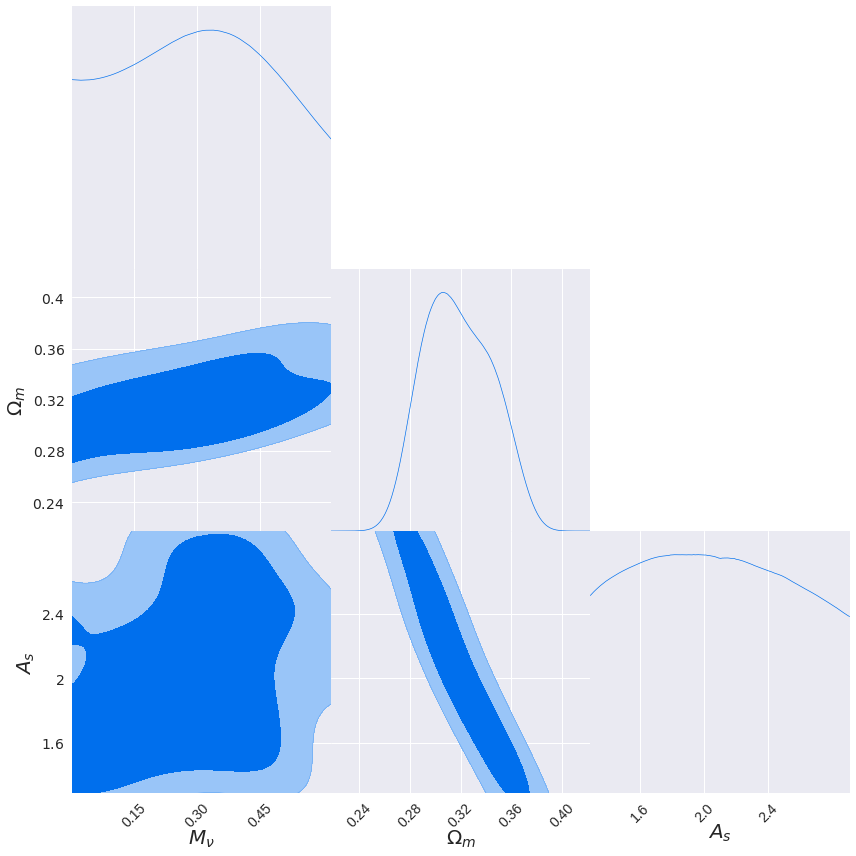

In [43]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples],savefig=True, filename=restorepath+'simpleMAFS1.png')

In [0]:
samples = []
for i in range(4):
    samples.append(DelfiEnsemble.emcee_sample(log_likelihood=lambda x: DelfiEnsemble.log_posterior_individual(i, x)))

Removed no burn in


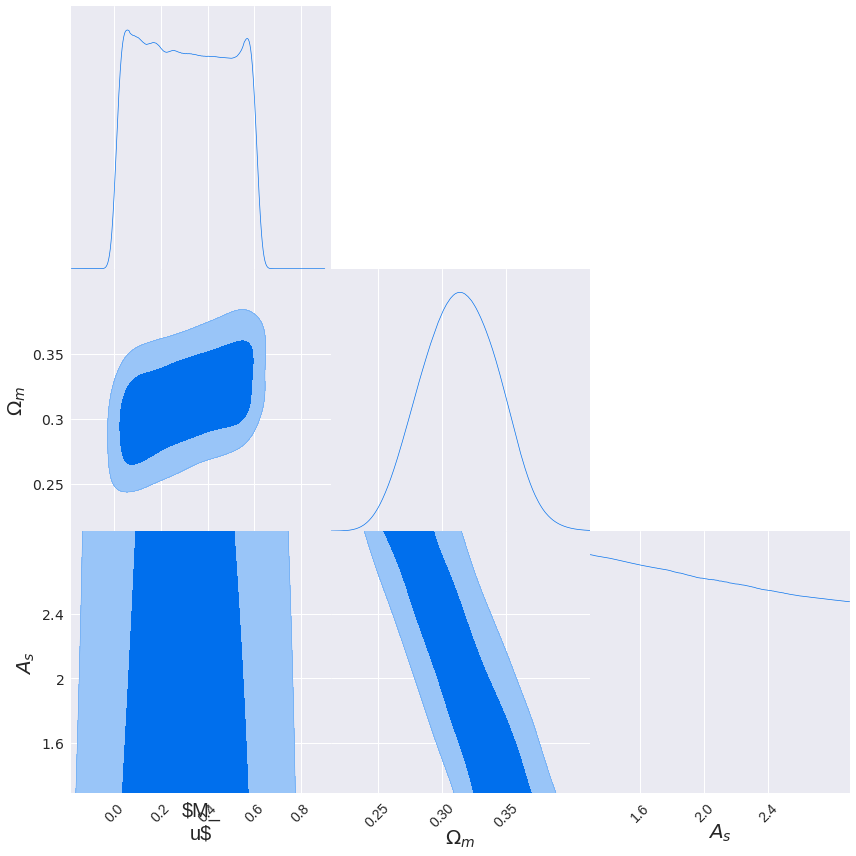

Removed no burn in


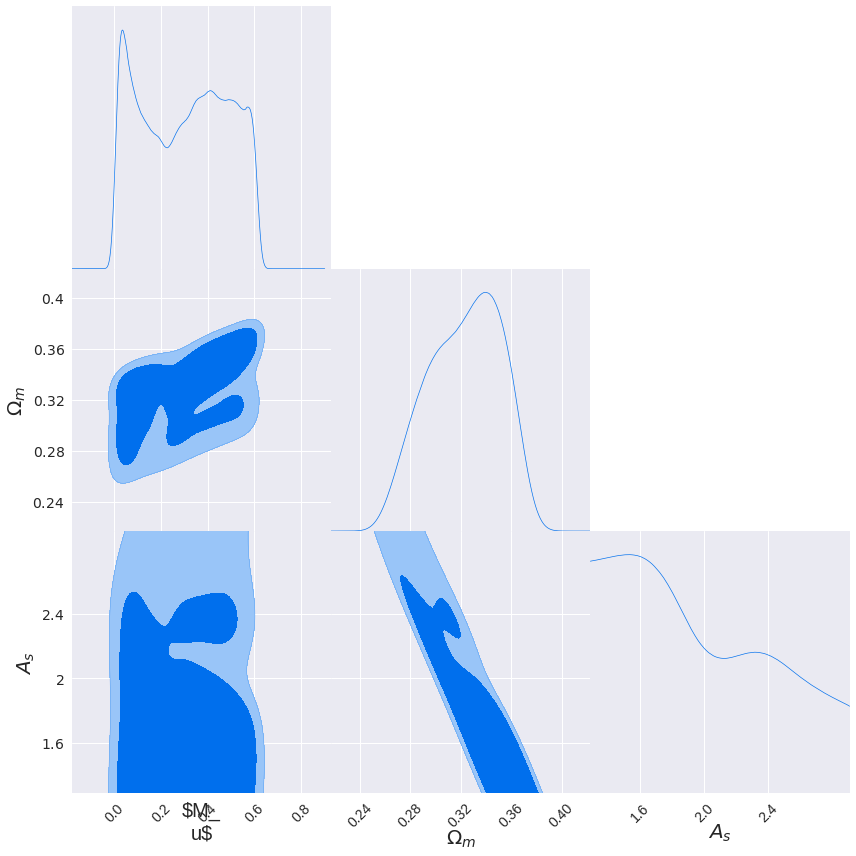

Removed no burn in


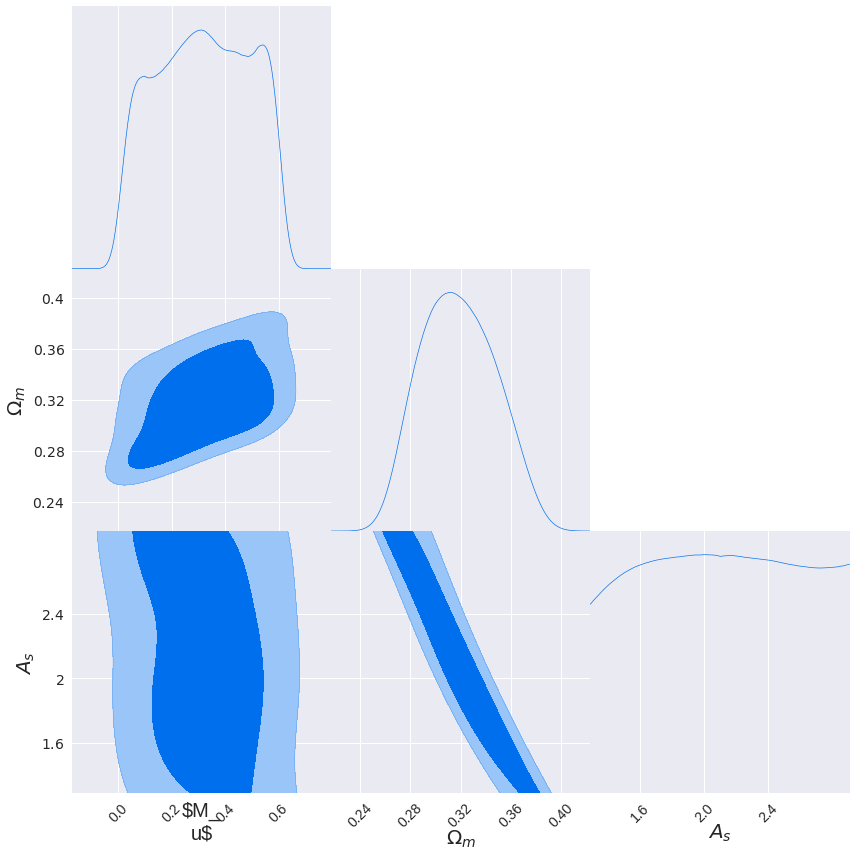

Removed no burn in


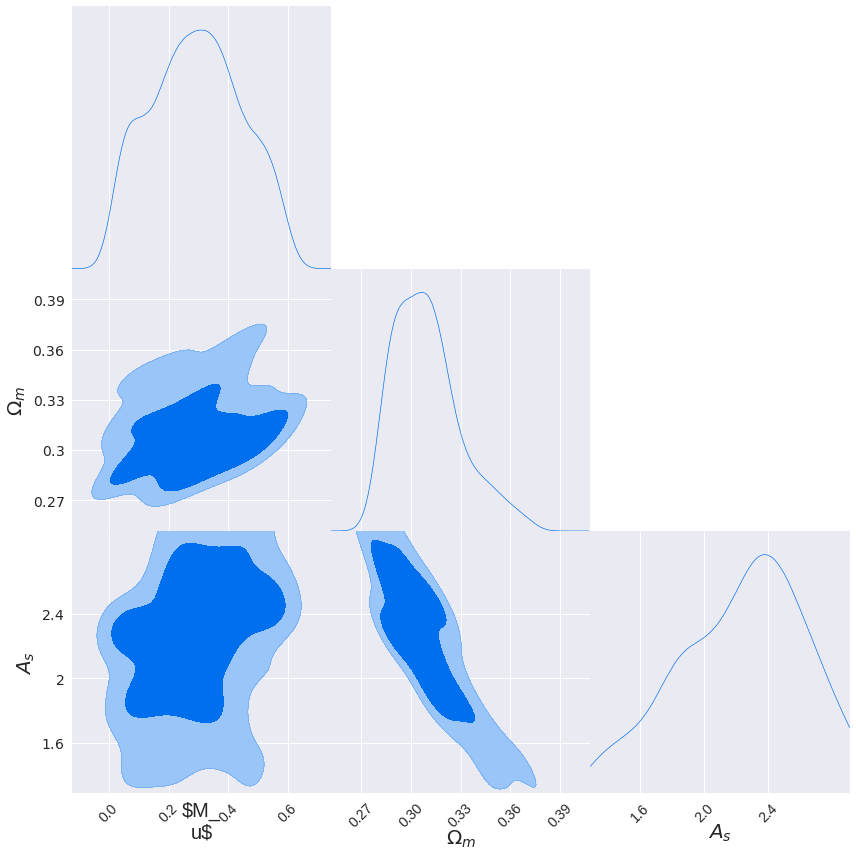

In [38]:
for i in range(4):
    DelfiEnsemble.triangle_plot(samples=samples[i:i+1])

In [41]:
DelfiEnsemble.adv_triangle_plot(prior=prior, val_true = data_scaled_c_data[0],val_fid=theta_fiducial,samples=[posterior_samples],plot_fid=True)

AttributeError: ignored